In [ ]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import splitfolders
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.keras import optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc








# **importing and cleaning the dataset**

In [ ]:
dataset_path = "/content/drive/My Drive/Pneumonia dataset-Copy/split_chest_xray"

for root, _, files in os.walk(dataset_path):
    for file in files:
        file_path = os.path.join(root, file)
        try:
            with Image.open(file_path) as img:
                img.verify()
        except (IOError, SyntaxError) as e:
            print(f"Removing corrupted image: {file_path}")
            os.remove(file_path)


Removing corrupted image: /content/drive/My Drive/Pneumonia dataset-Copy/split_chest_xray/train/NORMAL/IM-0531-0001-0001.jpeg


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Building the model using DenseNet121**

In [ ]:
model = Sequential()

base_model = DenseNet121(weights='imagenet',
                         include_top=False,
                         input_shape=(128, 128, 3))
base_model.trainable = False
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))


model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 4, 4, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,088,129 (30.85 MB)

 Trainable params: 1,050,625 (4.01 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
optimizer = SGD(learning_rate=0.001)
loss_function = BinaryCrossentropy(from_logits=False)
model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=['accuracy'])

# **Spliting and Augmenting the dataset**

In [ ]:

input_folder = "/content/drive/My Drive/Pneumonia dataset - Copy/chest_xray/train"

output_folder = "/content/drive/My Drive/Pneumonia dataset-Copy/split_chest_xray"

splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(0.8, 0.1, 0.1))


Copying files: 5112 files [05:55, 14.38 files/s]


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/My Drive/Pneumonia dataset-Copy/split_chest_xray/train',
    target_size=(128, 128),
    batch_size=32,
    class_mode="binary"
)

validation_generator = validation_datagen.flow_from_directory(
    '/content/drive/My Drive/Pneumonia dataset-Copy/split_chest_xray/val',
    target_size=(128, 128),
    batch_size=32,
    class_mode="binary"
)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '/content/drive/My Drive/Pneumonia dataset-Copy/split_chest_xray/test',
    target_size=(128, 128),
    batch_size=20,
    class_mode='binary',
    shuffle=False
)


Found 4088 images belonging to 2 classes.
Found 511 images belonging to 2 classes.
Found 512 images belonging to 2 classes.


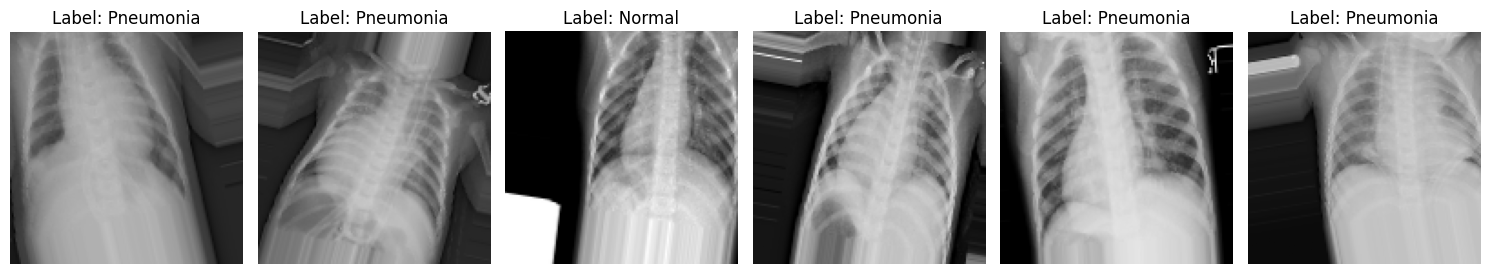

In [ ]:
images, labels = next(train_generator)

fig, axes = plt.subplots(1, 6, figsize=(15, 3))
for i in range(6):
    axes[i].imshow(images[i])  # Plot the image
    label = 'Pneumonia' if labels[i] == 1 else 'Normal'
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()


# **Training the Model**

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stopping, learning_rate_reduction]
)

Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 340s 2s/step - accuracy: 0.8291 - loss: 0.4887 - val_accuracy: 0.8513 - val_loss: 0.3447 - learning_rate: 0.0010
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 375s 2s/step - accuracy: 0.8628 - loss: 0.3295 - val_accuracy: 0.8689 - val_loss: 0.2930 - learning_rate: 0.0010
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 327s 2s/step - accuracy: 0.8706 - loss: 0.2930 - val_accuracy: 0.8865 - val_loss: 0.2833 - learning_rate: 0.0010
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 316s 2s/step - accuracy: 0.8868 - loss: 0.2665 - val_accuracy: 0.8943 - val_loss: 0.2589 - learning_rate: 0.0010
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 323s 2s/step - accuracy: 0.9001 - loss: 0.2412 - val_accuracy: 0.8982 - val_loss: 0.2601 - learning_rate: 0.0010
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 318s 2s/step - accuracy: 0.9054 - loss: 0.2347 - val_accuracy: 0.9080 - val_loss: 0.2300 - learning_rate: 0.0010
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 313s 2s/step - accuracy: 0.8922 - loss: 0.

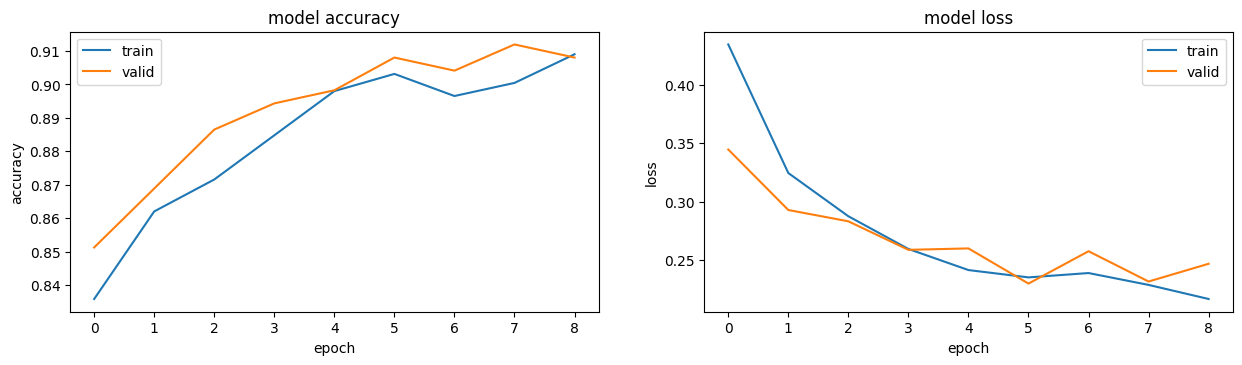

In [ ]:
plt.figure(1, figsize = (15,8))

plt.subplot(221)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])

plt.subplot(222)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])

plt.show()

# **Evaluating and predicting**

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


26/26 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.8639 - loss: 0.3061
Test Loss: 0.24698805809020996, Test Accuracy: 0.896484375


In [ ]:
y_pred = model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype(int)
y_true = test_generator.classes


26/26 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step


# **Confusion Matrix**

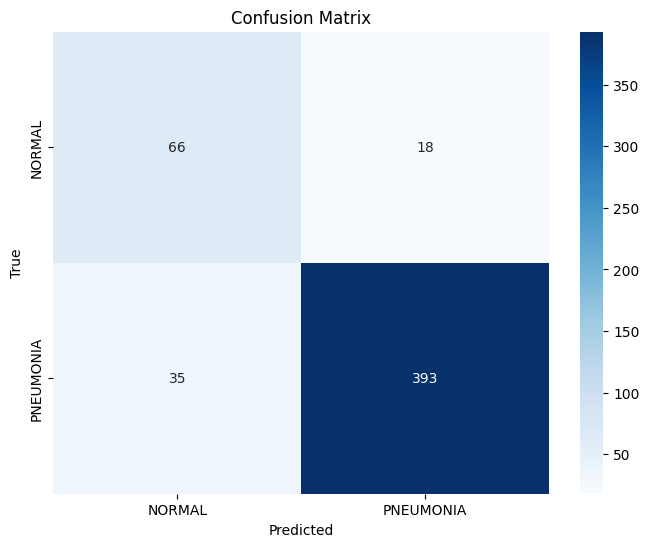

In [ ]:
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# **Classification report**

In [ ]:

report = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys())
print(report)


              precision    recall  f1-score   support

      NORMAL       0.65      0.79      0.71        84
   PNEUMONIA       0.96      0.92      0.94       428

    accuracy                           0.90       512
   macro avg       0.80      0.85      0.83       512
weighted avg       0.91      0.90      0.90       512



# **AUC and ROC**

In [ ]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

print(f"AUC: {roc_auc}")



AUC: 0.9482643524699599


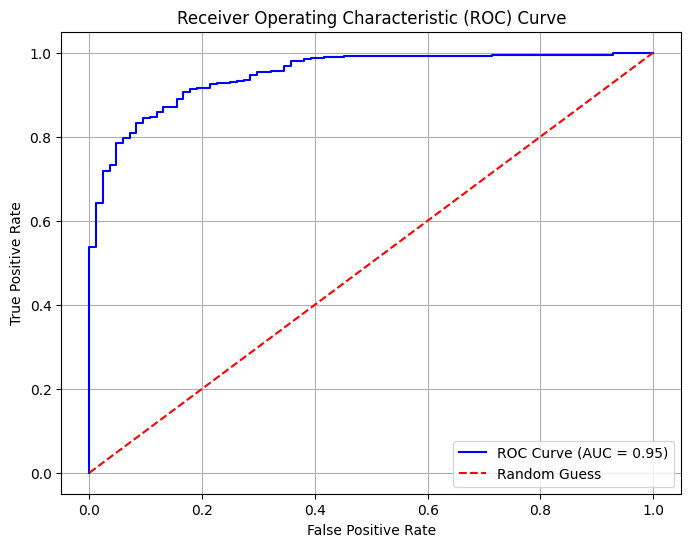

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()
